# Read Classifier Data 

In [2]:
import os
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torchvision
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms as transforms

#For converting the dataset to torchvision dataset format
class VowelConsonantDataset(Dataset):
    def __init__(self, file_path,train=True,transform=None):
        self.transform = transform
        self.file_path=file_path
        self.train=train
        self.file_names=[file for _,_,files in os.walk(self.file_path) for file in files]
        self.len = len(self.file_names)
        if self.train:
            self.classes_mapping=self.get_classes()
    def __len__(self):
        return len(self.file_names)
    
    def __getitem__(self, index):
        file_name=self.file_names[index]
        image_data=self.pil_loader(self.file_path+"/"+file_name)
        if self.transform:
            image_data = self.transform(image_data)
        if self.train:
            file_name_splitted=file_name.split("_")
            Y1 = self.classes_mapping[file_name_splitted[0]]
            Y2 = self.classes_mapping[file_name_splitted[1]]
            z1,z2=torch.zeros(10),torch.zeros(10)
            z1[Y1-10],z2[Y2]=1,1
            label=torch.stack([z1,z2])
            
            return image_data, label

        else:
            vow_test_tensor, con_test_tensor = torch.zeros(10,dtype=torch.int64), torch.zeros(10,dtype=torch.int64)
            numeric = file_name.split('.')[0]
            if len(numeric) < 4:
              numeric = '0'*(4-len(numeric))+numeric
            if numeric == '10000':
              numeric = '9999'
            vow_test_tensor[int(numeric[0])] = 1
            con_test_tensor[int(numeric[1])] = 1
            test_label = torch.stack([vow_test_tensor,con_test_tensor])
            return image_data, test_label
          
    def pil_loader(self,path):
        with open(path, 'rb') as f:
            img = Image.open(f)
            return img.convert('RGB')

      
    def get_classes(self):
        classes=[]
        for name in self.file_names:
            name_splitted=name.split("_")
            classes.extend([name_splitted[0],name_splitted[1]])
        classes=list(set(classes))
        classes_mapping={}
        for i,cl in enumerate(sorted(classes)):
            classes_mapping[cl]=i
        return classes_mapping
    

# Imports and Data download

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import matplotlib.pyplot as plt
from torchvision import datasets

import torchvision.transforms as transforms

import numpy as np
import pandas as pd

train_on_gpu = torch.cuda.is_available()

In [4]:
import importlib
if importlib.util.find_spec('mlflow') is None:
  !pip install mlflow
import mlflow
import mlflow.pytorch

     |████████████████████████████████| 12.0MB 210kB/s 
     |████████████████████████████████| 460kB 41.3MB/s 
     |████████████████████████████████| 81kB 9.7MB/s 
     |████████████████████████████████| 153kB 44.2MB/s 
     |████████████████████████████████| 286kB 42.0MB/s 
     |████████████████████████████████| 51kB 7.0MB/s 
     |████████████████████████████████| 1.1MB 39.6MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 6.0MB 34.6MB/s 
     |████████████████████████████████| 71kB 7.2MB/s 
     |████████████████████████████████| 204kB 37.4MB/s 
     |████████████████████████████████| 92kB 8.4MB/s 
     |████████████████████████████████| 2.7MB 36.3MB/s 
     |████████████████████████████████| 122kB 39.7MB/s 
     |████████████████████████████████| 81kB 7.9MB/s 
     |████████████████████████████████| 51kB 5.9MB/s 
  Created wheel for alembic: filename=alembic-

In [5]:
if importlib.util.find_spec('google.colab'):
  from google.colab import drive
  drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [6]:
!mkdir -p hin_classifier
!unzip -nq "/content/drive/My Drive/hin_classifier/train.zip" -d hin_classifier
!unzip -nq "/content/drive/My Drive/hin_classifier/test.zip" -d hin_classifier

# Utilities

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [8]:
def label_tensor(actual_labels):
    return torch.LongTensor([torch.max(labels, dim = -1)[1].item() for labels in actual_labels])

In [9]:
def cumulative_loss(predicted, actual, compute_loss=nn.CrossEntropyLoss()):
  vow_labels = label_tensor(actual[:,0,:]).to(device)
  con_labels = label_tensor(actual[:,1,:]).to(device)

  loss = compute_loss(predicted, vow_labels)
  #loss += compute_loss(predicted, con_labels)
  return loss


In [10]:
def cumulative_correctness(predicted, actual):
  vow_test = label_tensor(actual[:,0,:].data).to(device)
  con_test = label_tensor(actual[:,1,:].data).to(device)
  correct_value = predicted.eq(vow_test).sum().item()
  #correct_value += predicted.eq(con_test).sum().item()
  return correct_value



In [11]:
def standalone_correctness(predicted, actual):
  return predicted.eq(actual.data).sum().item()

# Plot Images

In [12]:
def imshow(img, title):
    
    plt.figure(figsize=(4 , 4))
    plt.axis('off')
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.title(title)
    plt.show()

In [13]:
def show_batch_images(dataloader):
    images, labels = next(iter(dataloader))
    
    img = torchvision.utils.make_grid(images)
    imshow(img, title='Plot')
    
    return images, labels

# Train And Test Modules

In [62]:
class Params(object):
    def __init__(self, batch_size, epochs, seed, log_interval):
        self.batch_size = batch_size
        self.epochs = epochs
        self.seed = seed
        self.log_interval = log_interval

max_epochs = 50 if torch.cuda.is_available() else 2
args = Params(75, max_epochs, 0, 20)

In [15]:
def train(train_data_set,network, optimise, epoch, compute_loss):
    
  network.train()
  for batch_id, data in enumerate(train_data_set):
    inputs, labels = data
            
    optimise.zero_grad()
    inputs = inputs.to(device)
    outputs = network(inputs)
                  
    loss = compute_loss(outputs, labels)

    loss.backward()
    optimise.step()
      
    if batch_id % args.log_interval == 0:
      pos = epoch * len(train_data_set) + batch_id
      mlflow.log_metric('train_loss', loss.data.item()/len(inputs)*1000)
          
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.3f}'.format(
              epoch, batch_id * len(inputs), len(train_data_set.dataset),
              100. * batch_id / len(train_data_set), loss.data.item()))

In [16]:
def test(test_data_set, network, epoch, compute_loss, compute_correctness):
    
    network.eval()
    test_loss = 0
    correct = 0
    confusion_matrix = np.zeros([10, 10])
    
    with torch.no_grad():
        
        for inputs, labels in test_data_set:
            inputs = inputs.to(device)
            outputs = network(inputs)
            test_loss += compute_loss(outputs, labels).data.item()
            pred = outputs.data.max(1)[1]

            correct += compute_correctness(pred,labels)
            
            for x, y in zip(pred.cpu().numpy(), labels.numpy()):
                confusion_matrix[x][y] += 1
            
        test_loss /= len(test_data_set.dataset)
        test_accuracy = 100.0 * correct / len(test_data_set.dataset)
        
        mlflow.log_metric('test_loss', test_loss*1000)
        mlflow.log_metric('test_accuracy', test_accuracy)
        
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.
              format(test_loss, correct, len(test_data_set.dataset), test_accuracy))
              
        if epoch == args.epochs:
            classes = np.arange(10)
            fig, ax = plt.subplots()
            im = ax.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
            ax.figure.colorbar(im, ax=ax)
            ax.set(xticks=np.arange(confusion_matrix.shape[1]),
                       yticks=np.arange(confusion_matrix.shape[0]),
                       xticklabels=classes, yticklabels=classes,
                       ylabel='True label',
                       xlabel='Predicted label',
                       title='Epoch %d' % epoch)
            thresh = confusion_matrix.max() / 2.
            for i in range(confusion_matrix.shape[0]):
                for j in range(confusion_matrix.shape[1]):
                    ax.text(j, i, int(confusion_matrix[i, j]),
                            ha="center", va="center",
                            color="white" if confusion_matrix[i, j] > thresh else "black")
              
            fig.tight_layout()
              
            image_path = 'images/%s.png' % (expt_id)
            plt.savefig(image_path)
            mlflow.log_artifact(image_path)


# Feed Forward Network

In [43]:
class FeedForwardNetwork(nn.Module):
    def __init__(self): 
        super(FeedForwardNetwork, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(12288, 4096),  # 64 x 64 x 3 = 12288
            nn.ReLU(),
            nn.Linear(4096, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Linear(16, 10)
        )
             
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Data Loader

In [63]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),])

In [64]:
full_data = VowelConsonantDataset("hin_classifier/train",train=True,transform=transform)
train_size = int(0.9 * len(full_data))
test_size = len(full_data) - train_size

train_data, validation_data = random_split(full_data, [train_size, test_size])

train_loader = torch.utils.data.DataLoader(train_data, batch_size=args.batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_data, batch_size=args.batch_size, shuffle=True)

In [65]:
test_data = VowelConsonantDataset("hin_classifier/test",train=False,transform=transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=args.batch_size,shuffle=False)

# Run ffn with classifier data

In [48]:
%%time
ffn = FeedForwardNetwork().to(device)
for epoch in range(args.epochs):
  train(train_loader,ffn, optim.Adam(ffn.parameters()), epoch,cumulative_loss)
  test(test_loader,ffn, epoch,cumulative_loss, cumulative_correctness)

Train Epoch: 0 [0/9000 (0%)]	Loss: 2.286
Train Epoch: 0 [1000/9000 (11%)]	Loss: 2.326
Train Epoch: 0 [2000/9000 (22%)]	Loss: 2.378
Train Epoch: 0 [3000/9000 (33%)]	Loss: 2.272
Train Epoch: 0 [4000/9000 (44%)]	Loss: 2.328
Train Epoch: 0 [5000/9000 (56%)]	Loss: 2.286
Train Epoch: 0 [6000/9000 (67%)]	Loss: 2.300
Train Epoch: 0 [7000/9000 (78%)]	Loss: 2.287
Train Epoch: 0 [8000/9000 (89%)]	Loss: 2.299

Test set: Average loss: 0.0461, Accuracy: 1063/10000 (11%)

Train Epoch: 1 [0/9000 (0%)]	Loss: 2.294
Train Epoch: 1 [1000/9000 (11%)]	Loss: 2.327
Train Epoch: 1 [2000/9000 (22%)]	Loss: 2.348
Train Epoch: 1 [3000/9000 (33%)]	Loss: 2.325
Train Epoch: 1 [4000/9000 (44%)]	Loss: 2.273
Train Epoch: 1 [5000/9000 (56%)]	Loss: 2.244
Train Epoch: 1 [6000/9000 (67%)]	Loss: 2.281
Train Epoch: 1 [7000/9000 (78%)]	Loss: 2.292
Train Epoch: 1 [8000/9000 (89%)]	Loss: 2.290

Test set: Average loss: 0.0452, Accuracy: 1315/10000 (13%)

Train Epoch: 2 [0/9000 (0%)]	Loss: 2.256
Train Epoch: 2 [1000/9000 (11%)]	Lo

In [ ]:
if importlib.util.find_spec('google.colab'):
  from google.colab import files
  files.download('/content/mlruns')

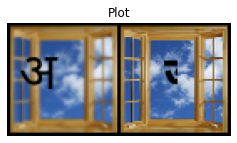

In [ ]:
train_loader_double = torch.utils.data.DataLoader(train_data, batch_size=2, shuffle=True)
x, y = show_batch_images(train_loader_double)

# Convolutional Network

In [66]:
class CnnFc(nn.Module):
  def __init__(self):
    super(CnnFc, self).__init__()
    self.features = nn.Sequential(
    nn.Conv2d(3, 243, 3, padding=1),       
    nn.AvgPool2d(2, stride=2),  
    nn.LeakyReLU(),
    nn.Conv2d(243, 243, 3, padding=1),
    nn.BatchNorm2d(243),
    nn.LeakyReLU(),
    nn.Conv2d(243, 81, 3, padding=1),
    nn.BatchNorm2d(81),
    nn.LeakyReLU(),
    nn.Conv2d(81, 27, 3, padding=1),
    nn.BatchNorm2d(27),
    nn.LeakyReLU(),  
    nn.Conv2d(27, 9, 3, padding=1),
    nn.BatchNorm2d(9),
    nn.LeakyReLU(),           
    nn.Conv2d(9, 3, 3, padding=1),
    nn.BatchNorm2d(3),
    nn.AvgPool2d(2),
    nn.LeakyReLU()               
    )

    self.classifier = nn.Sequential(
    nn.Linear(768, 50),         
    nn.LeakyReLU(),
    nn.Linear(50, 1024),         
    nn.LeakyReLU(),
    nn.Linear(1024, 256),         
    nn.LeakyReLU(),
    nn.Linear(256, 64),         
    nn.LeakyReLU(),
    nn.Linear(64, 16),         
    nn.LeakyReLU(),
    nn.Linear(16,10)            
    )

  def forward(self, x):
    x = self.features(x)
    x = x.view(x.size(0), -1)
    x = self.classifier(x)
    return x


In [67]:
%%time
cnnfc = CnnFc().to(device)
for epoch in range(args.epochs):
  train(train_loader,cnnfc, optim.Adam(cnnfc.parameters(), lr = 0.01, betas=(0.7,0.8)), epoch,cumulative_loss)
  test(test_loader,cnnfc, epoch,cumulative_loss, cumulative_correctness)

Train Epoch: 0 [0/9000 (0%)]	Loss: 2.339
Train Epoch: 0 [1500/9000 (17%)]	Loss: 2.307
Train Epoch: 0 [3000/9000 (33%)]	Loss: 2.310
Train Epoch: 0 [4500/9000 (50%)]	Loss: 2.313
Train Epoch: 0 [6000/9000 (67%)]	Loss: 2.310
Train Epoch: 0 [7500/9000 (83%)]	Loss: 2.302

Test set: Average loss: 0.0309, Accuracy: 1000/10000 (10%)

Train Epoch: 1 [0/9000 (0%)]	Loss: 2.302
Train Epoch: 1 [1500/9000 (17%)]	Loss: 2.297
Train Epoch: 1 [3000/9000 (33%)]	Loss: 2.295
Train Epoch: 1 [4500/9000 (50%)]	Loss: 2.317
Train Epoch: 1 [6000/9000 (67%)]	Loss: 2.304
Train Epoch: 1 [7500/9000 (83%)]	Loss: 2.307

Test set: Average loss: 0.0305, Accuracy: 1305/10000 (13%)

Train Epoch: 2 [0/9000 (0%)]	Loss: 2.289
Train Epoch: 2 [1500/9000 (17%)]	Loss: 2.212
Train Epoch: 2 [3000/9000 (33%)]	Loss: 2.241
Train Epoch: 2 [4500/9000 (50%)]	Loss: 2.185
Train Epoch: 2 [6000/9000 (67%)]	Loss: 2.158
Train Epoch: 2 [7500/9000 (83%)]	Loss: 2.052

Test set: Average loss: 0.0269, Accuracy: 1922/10000 (19%)

Train Epoch: 3 [0/9

# MNIST Data Set

> *Network*



In [33]:
class MNISTFFn(nn.Module):
    def __init__(self, nH = 32): 
        super(MNISTFFn, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(784, nH),  # 28 x 28 = 784
            nn.ReLU(),
            nn.Linear(nH, 10)
        )
             
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [34]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_set = datasets.MNIST('../data', train=True, download=True, 
                         transform=transform)

test_set = datasets.MNIST('../data', train=False, download=True, 
                         transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=args.batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=args.batch_size, shuffle=False)

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw




Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [39]:
%%time
for epoch in range(args.epochs):
  mnistffn = MNISTFFn().to(device)
  train(train_loader,mnistffn, optim.Adam(mnistffn.parameters()), epoch,nn.CrossEntropyLoss())
  test(test_loader,mnistffn, epoch,nn.CrossEntropyLoss(), standalone_correctness)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.387
Train Epoch: 0 [1000/60000 (2%)]	Loss: 1.482
Train Epoch: 0 [2000/60000 (3%)]	Loss: 0.996
Train Epoch: 0 [3000/60000 (5%)]	Loss: 0.559
Train Epoch: 0 [4000/60000 (7%)]	Loss: 0.375
Train Epoch: 0 [5000/60000 (8%)]	Loss: 0.405
Train Epoch: 0 [6000/60000 (10%)]	Loss: 0.430
Train Epoch: 0 [7000/60000 (12%)]	Loss: 0.375
Train Epoch: 0 [8000/60000 (13%)]	Loss: 0.596
Train Epoch: 0 [9000/60000 (15%)]	Loss: 0.309
Train Epoch: 0 [10000/60000 (17%)]	Loss: 0.307
Train Epoch: 0 [11000/60000 (18%)]	Loss: 0.343
Train Epoch: 0 [12000/60000 (20%)]	Loss: 0.228
Train Epoch: 0 [13000/60000 (22%)]	Loss: 0.305
Train Epoch: 0 [14000/60000 (23%)]	Loss: 0.204
Train Epoch: 0 [15000/60000 (25%)]	Loss: 0.261
Train Epoch: 0 [16000/60000 (27%)]	Loss: 0.349
Train Epoch: 0 [17000/60000 (28%)]	Loss: 0.287
Train Epoch: 0 [18000/60000 (30%)]	Loss: 0.260
Train Epoch: 0 [19000/60000 (32%)]	Loss: 0.308
Train Epoch: 0 [20000/60000 (33%)]	Loss: 0.287
Train Epoch: 0 [21000/60000 (35%

TypeError: ignored